# Industrial Anomaly Detection: Specialized SAM for Carpet Defects

## Project Goal
Detect subtle industrial defects (cuts, holes, thread pulls) on carpet textures.
Base SAM often treats the entire carpet surface as one object. We will train a **Specialized SAM Decoder** to recognize that "texture interruption" defines an object boundary.

## Dataset: MVTec AD (Carpet)
- **Train:** 280 "Good" (Defect-free) images.
- **Test:** 89 Defect images (Color, Cut, Hole, Metal, Thread) + 28 Good images.
- **Strategy:** We will train on **Synthetic Defects** generated from the Good images, then test on Real Defects.

In [10]:
!tar -xf /content/carpet.tar.xz

In [11]:
# ==== STEP 1: INSTALL DEPENDENCIES ====
try:
    import mobile_sam
    print("MobileSAM already installed.")
except ImportError:
    print("Installing MobileSAM...")
    %pip install git+https://github.com/ChaoningZhang/MobileSAM.git
    %pip install timm opencv-python

import os
import cv2
import random
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from mobile_sam import sam_model_registry, SamPredictor

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# Fix Seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

MobileSAM already installed.
Using device: cuda


In [18]:
# ==== STEP 2: DATA PATHS & WEIGHTS ====
# Adjust these to your folder structure
DATA_ROOT = Path('carpet')
TRAIN_DIR = DATA_ROOT / 'train' / 'good'
TEST_DIR = DATA_ROOT / 'test'
GT_DIR = DATA_ROOT / 'ground_truth'

# Download MobileSAM weights
WEIGHTS_DIR = Path('weights')
WEIGHTS_DIR.mkdir(exist_ok=True)
CHECKPOINT_PATH = WEIGHTS_DIR / "mobile_sam.pt"

if not CHECKPOINT_PATH.exists():
    print("Downloading weights...")
    !wget -P weights https://github.com/ChaoningZhang/MobileSAM/raw/master/weights/mobile_sam.pt

train_files = sorted(list(TRAIN_DIR.glob('*.png')))
print(f"Training Images (Good): {len(train_files)}")

Training Images (Good): 280


In [19]:
TRAIN_DIR = DATA_ROOT / 'train' / 'good'
train_files = sorted(list(TRAIN_DIR.glob('*.png')))
print(f"Training Images (Good): {len(train_files)}")

Training Images (Good): 280


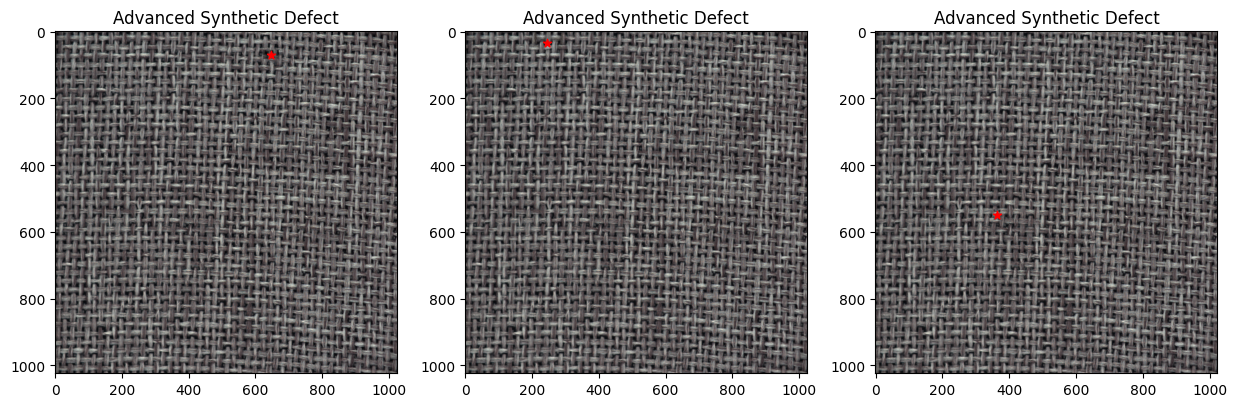

In [25]:
# ==== STEP 3: ADVANCED SYNTHETIC DEFECT GENERATOR ====
# We create three types of defects to match the MVTec classes:
# 1. CutPaste (Patches) -> Matches 'hole', 'metal', 'cut'
# 2. Scars (Lines) -> Matches 'thread', 'cut'
# 3. Stains (Color Shift) -> Matches 'color'

def generate_synthetic_anomaly(image_path):
    img = cv2.imread(str(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape
    mask = np.zeros((h, w), dtype=np.uint8)
    aug_img = img.copy()

    defect_type = random.choice(['patch', 'scar', 'stain'])

    if defect_type == 'patch':
        # ---- TYPE 1: CutPaste Patch (Hole/Metal) ----
        pw, ph = random.randint(20, 60), random.randint(20, 60)
        src_x, src_y = random.randint(0, w-pw), random.randint(0, h-ph)
        dst_x, dst_y = random.randint(0, w-pw), random.randint(0, h-ph)

        patch = img[src_y:src_y+ph, src_x:src_x+pw].copy()

        # Make it look distinct (Darker/Brighter/Noise)
        if random.random() < 0.5:
            patch = (patch * random.uniform(0.4, 0.7)).astype(np.uint8) # Dark Hole
        else:
            noise = np.random.normal(0, 30, patch.shape).astype(np.int16)
            patch = np.clip(patch + noise, 0, 255).astype(np.uint8) # Textured Object

        aug_img[dst_y:dst_y+ph, dst_x:dst_x+pw] = patch
        mask[dst_y:dst_y+ph, dst_x:dst_x+pw] = 1

    elif defect_type == 'scar':
        # ---- TYPE 2: Scar/Thread (Thin Lines) ----
        # Draw a random bezier-like curve or line
        pt1 = (random.randint(0, w), random.randint(0, h))
        pt2 = (random.randint(0, w), random.randint(0, h))
        thickness = random.randint(2, 5)
        color = (random.randint(0, 50), random.randint(0, 50), random.randint(0, 50)) # Dark thread

        cv2.line(aug_img, pt1, pt2, color, thickness)
        cv2.line(mask, pt1, pt2, 1, thickness)

    elif defect_type == 'stain':
        # ---- TYPE 3: Stain (Large Diffuse Color Shift) ----
        radius = random.randint(40, 100)
        center = (random.randint(0, w), random.randint(0, h))

        # Create circular mask for stain
        stain_mask = np.zeros((h, w), dtype=np.uint8)
        cv2.circle(stain_mask, center, radius, 1, -1)

        # Apply color shift
        overlay = aug_img.copy()
        # Convert to HSV to shift color
        hsv = cv2.cvtColor(overlay, cv2.COLOR_RGB2HSV)
        hsv[:, :, 0] = (hsv[:, :, 0] + random.randint(20, 50)) % 180 # Shift Hue
        shifted = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

        # Blend
        alpha = 0.4
        aug_img = np.where(stain_mask[..., None] == 1,
                           cv2.addWeighted(overlay, 1-alpha, shifted, alpha, 0),
                           aug_img)
        mask = np.maximum(mask, stain_mask)

    # Generate Prompt (Center of anomaly)
    ys, xs = np.where(mask > 0)
    if len(xs) > 0:
        center_x, center_y = int(np.mean(xs)), int(np.mean(ys))
        prompt = np.array([center_x, center_y])
    else:
        # Fallback
        prompt = np.array([w//2, h//2])

    return aug_img, mask, prompt

# Visualize Types
plt.figure(figsize=(15, 5))
for i in range(3):
    aug, m, p = generate_synthetic_anomaly(train_files[0])
    plt.subplot(1, 3, i+1)
    plt.imshow(aug)
    plt.scatter(p[0], p[1], c='red', marker='*')
    plt.title("Advanced Synthetic Defect")
plt.show()

In [26]:
# ==== STEP 4: PRE-COMPUTE EMBEDDINGS (Training Data) ====
# We generate N synthetic training examples and save their embeddings.

N_TRAIN_SAMPLES = 500
EMBED_DIR = Path('carpet_embeddings')
EMBED_DIR.mkdir(exist_ok=True)

# Load Model for Encoding
model = sam_model_registry['vit_t'](checkpoint=CHECKPOINT_PATH)
model.to(DEVICE)
predictor = SamPredictor(model)

metadata = []
print(f"Generating {N_TRAIN_SAMPLES} synthetic training samples...")

for i in range(N_TRAIN_SAMPLES):
    # Pick random base image
    src_file = random.choice(train_files)

    # Generate Anomaly
    aug_img, mask, prompt = generate_synthetic_anomaly(src_file)

    # Encode
    predictor.set_image(aug_img)
    embedding = predictor.get_image_embedding().cpu().numpy()

    # Save
    embed_path = EMBED_DIR / f"train_{i:04d}_embed.npy"
    mask_path = EMBED_DIR / f"train_{i:04d}_mask.npy"
    np.save(embed_path, embedding)
    np.save(mask_path, mask)

    metadata.append({
        'embed_path': str(embed_path),
        'mask_path': str(mask_path),
        'prompt_x': prompt[0],
        'prompt_y': prompt[1]
    })

    if (i+1) % 50 == 0: print(f"Processed {i+1}")

train_df = pd.DataFrame(metadata)

Generating 500 synthetic training samples...
Processed 50
Processed 100
Processed 150
Processed 200
Processed 250
Processed 300
Processed 350
Processed 400
Processed 450
Processed 500


In [28]:
# ==== STEP 5: TRAINING LOOP (Specialized Decoder) ====

class AnomalyDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        emb = torch.from_numpy(np.load(row['embed_path'])).to(DEVICE)
        mask = torch.from_numpy(np.load(row['mask_path'])).float().to(DEVICE)

        # Prompt (B, N, 2)
        point = torch.tensor([[row['prompt_x'], row['prompt_y']]], dtype=torch.float32).to(DEVICE)
        label = torch.tensor([1], dtype=torch.int64).to(DEVICE)

        return emb, mask.unsqueeze(0), point, label

train_ds = AnomalyDataset(train_df)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)

# Setup Model
model.train()
# Freeze Encoders
for p in model.image_encoder.parameters(): p.requires_grad = False
for p in model.prompt_encoder.parameters(): p.requires_grad = False

# Train Decoder Only
optimizer = torch.optim.AdamW(model.mask_decoder.parameters(), lr=1e-4)
loss_fn = torch.nn.MSELoss()

EPOCHS = 5
for epoch in range(EPOCHS):
    total_loss = 0
    for emb, gt_mask, point, label in train_loader:
        # Squeeze batch dim from embedding: (1, 1, 256, 64, 64) -> (1, 256, 64, 64)
        emb = emb.squeeze(1)

        # Embed Prompt
        with torch.no_grad():
            sparse, dense = model.prompt_encoder(
                points=(point, label), # Fixed: Removed .unsqueeze(1)
                boxes=None, masks=None
            )

        # Predict
        low_res_masks, _ = model.mask_decoder(
            image_embeddings=emb,
            image_pe=model.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse,
            dense_prompt_embeddings=dense,
            multimask_output=False
        )

        # Upscale
        pred_mask = F.interpolate(low_res_masks, size=(gt_mask.shape[2], gt_mask.shape[3]), mode='bilinear', align_corners=False)

        # Loss (Dice)
        pred = torch.sigmoid(pred_mask)
        intersection = (pred * gt_mask).sum()
        dice = 1 - (2. * intersection + 1.) / (pred.sum() + gt_mask.sum() + 1.)

        optimizer.zero_grad()
        dice.backward()
        optimizer.step()
        total_loss += dice.item()

    print(f"Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f}")

torch.save(model.mask_decoder.state_dict(), "carpet_decoder.pth")

Epoch 1 | Loss: 0.2544
Epoch 2 | Loss: 0.2006
Epoch 3 | Loss: 0.1818
Epoch 4 | Loss: 0.1639
Epoch 5 | Loss: 0.1527


Found 89 real defect test cases.
--- BASELINE SAM ---


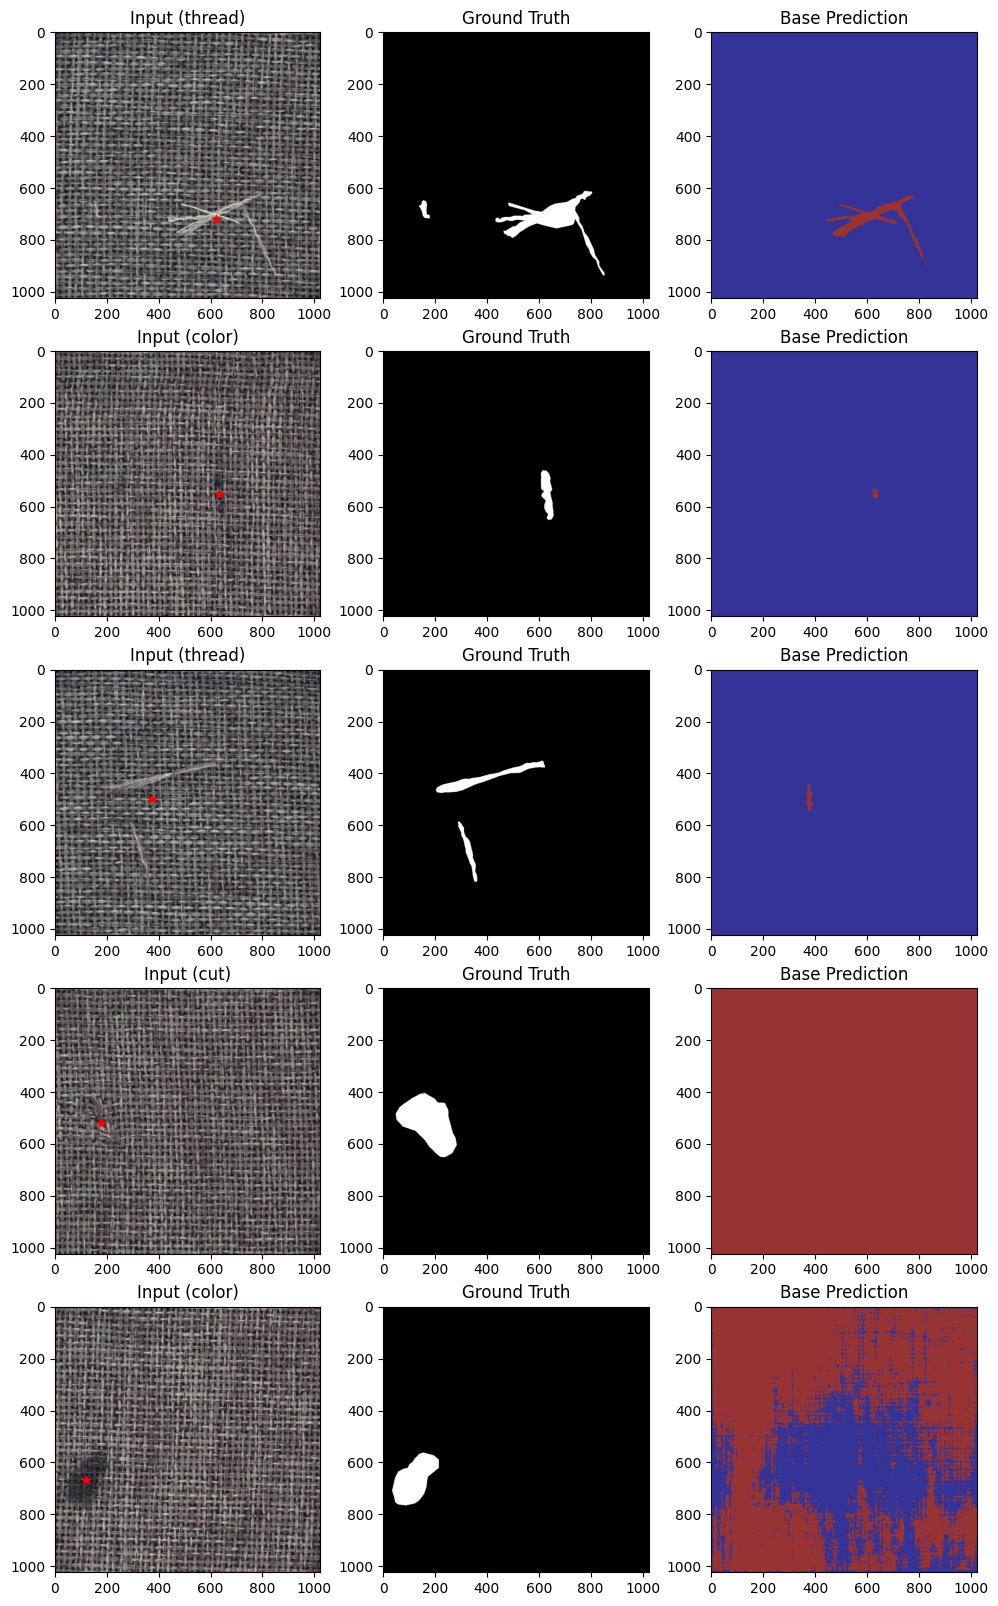

--- SPECIALIZED SAM ---


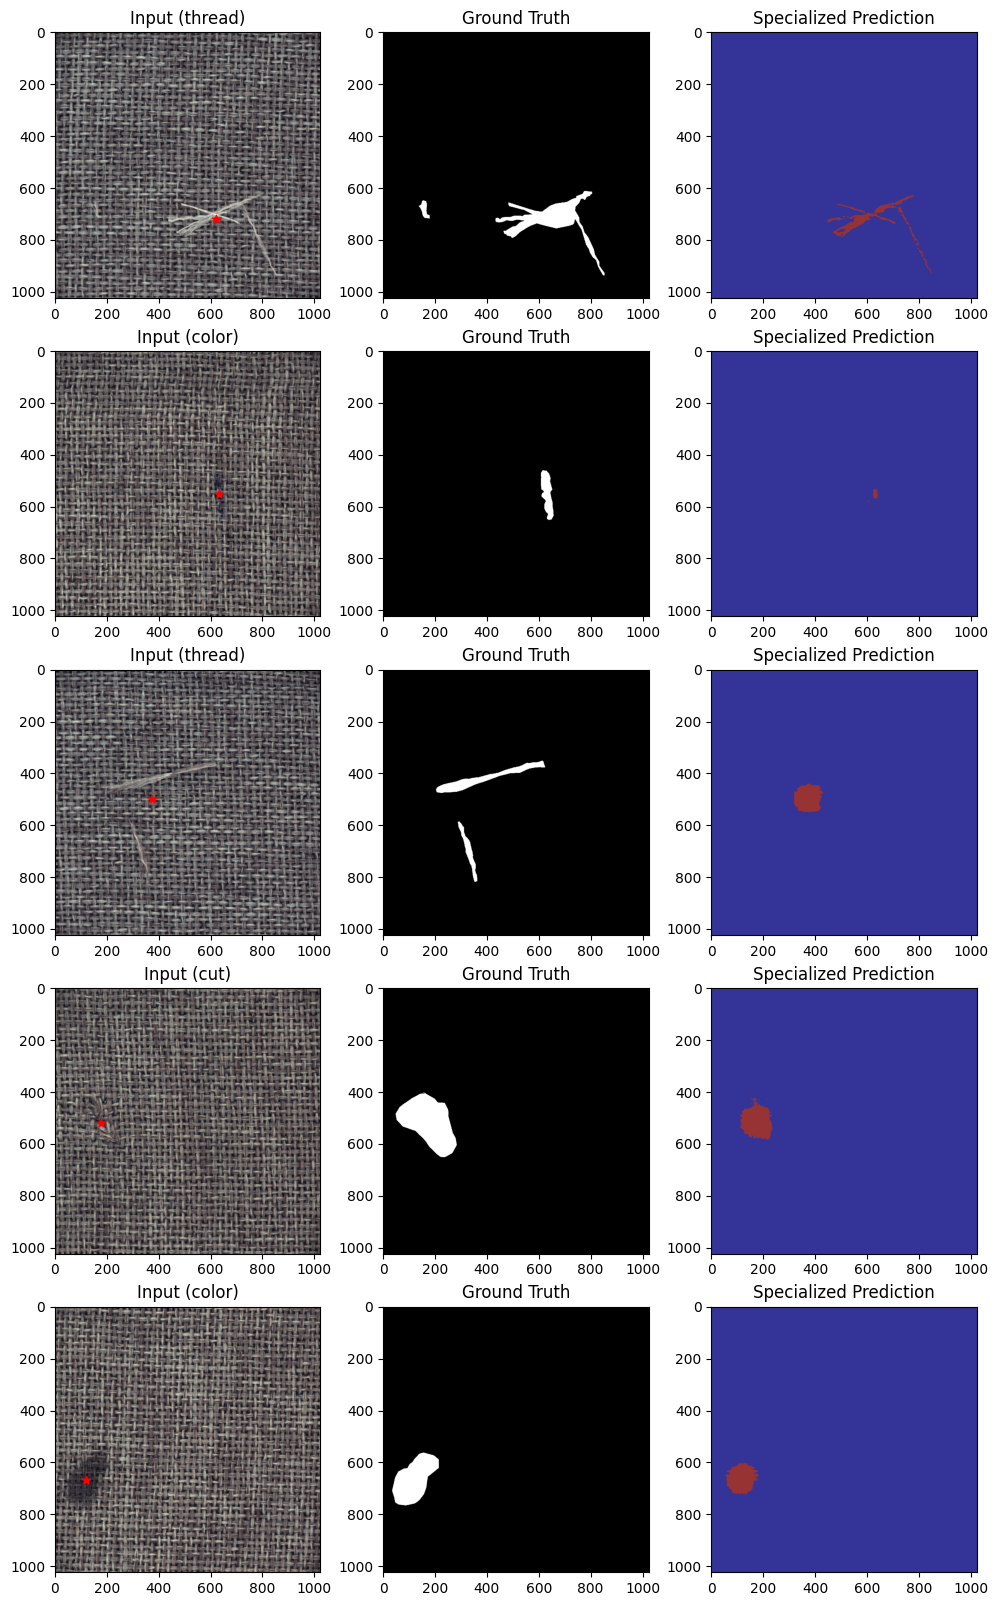

In [30]:
# ==== STEP 6: REAL DEFECT EVALUATION ====
# We iterate through the REAL test folder.

def get_real_test_samples(test_dir, gt_dir):
    samples = []
    # Categories: cut, hole, metal_contamination, thread, color
    defect_types = ['cut', 'hole', 'metal_contamination', 'thread', 'color']

    for dtype in defect_types:
        img_dir = test_dir / dtype
        mask_dir = gt_dir / dtype

        if not img_dir.exists(): continue

        for img_path in img_dir.glob('*.png'):
            mask_name = img_path.stem + '_mask.png'
            mask_path = mask_dir / mask_name

            if mask_path.exists():
                samples.append((str(img_path), str(mask_path), dtype))
    return samples

test_samples = get_real_test_samples(TEST_DIR, GT_DIR)
print(f"Found {len(test_samples)} real defect test cases.")

def evaluate_on_real(model_type='base', samples=test_samples[:5]):
    # Setup Predictor
    net = sam_model_registry['vit_t'](checkpoint=CHECKPOINT_PATH)
    if model_type == 'specialized':
        net.mask_decoder.load_state_dict(torch.load("carpet_decoder.pth"))
    net.to(DEVICE)
    net.eval()
    predictor = SamPredictor(net)

    fig, axes = plt.subplots(len(samples), 3, figsize=(12, 4*len(samples)))

    for i, (img_p, mask_p, dtype) in enumerate(samples):
        img = cv2.imread(img_p); img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_p, cv2.IMREAD_GRAYSCALE)

        # Find Center of Defect for Prompt
        ys, xs = np.where(mask > 0)
        if len(xs) == 0: continue # Skip empty masks

        cx, cy = int(np.mean(xs)), int(np.mean(ys))

        # Predict
        predictor.set_image(img)
        masks, _, _ = predictor.predict(
            point_coords=np.array([[cx, cy]]),
            point_labels=np.array([1]),
            multimask_output=False
        )

        # Visualize
        if len(samples) == 1: ax = axes
        else: ax = axes[i]

        ax[0].imshow(img); ax[0].set_title(f"Input ({dtype})")
        ax[0].scatter(cx, cy, c='red', marker='*')

        ax[1].imshow(mask, cmap='gray'); ax[1].set_title("Ground Truth")

        ax[2].imshow(masks[0], alpha=0.8, cmap='jet'); ax[2].set_title(f"{model_type.capitalize()} Prediction")

    plt.show()

# Run Comparison with FRESH RANDOMNESS
# Reset seed to current time so every run is different
np.random.seed(None)
sample_indices = np.random.choice(len(test_samples), 5, replace=False)
subset = [test_samples[i] for i in sample_indices]

print("--- BASELINE SAM ---")
evaluate_on_real('base', subset)

print("--- SPECIALIZED SAM ---")
evaluate_on_real('specialized', subset)

In [31]:
# ==== STEP 7: GLOBAL QUANTITATIVE EVALUATION ====
# Calculate mIoU over the entire test set (89 images)

def calculate_global_miou(model_type='base'):
    # Setup Predictor
    net = sam_model_registry['vit_t'](checkpoint=CHECKPOINT_PATH)
    if model_type == 'specialized':
        net.mask_decoder.load_state_dict(torch.load("carpet_decoder.pth"))
    net.to(DEVICE)
    net.eval()
    predictor = SamPredictor(net)

    ious = []
    print(f"Calculating Global mIoU for {model_type} model...")

    for (img_p, mask_p, dtype) in test_samples:
        img = cv2.imread(img_p); img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_p, cv2.IMREAD_GRAYSCALE)

        # Get Prompt
        ys, xs = np.where(mask > 0)
        if len(xs) == 0: continue
        cx, cy = int(np.mean(xs)), int(np.mean(ys))

        # Predict
        predictor.set_image(img)
        masks, _, _ = predictor.predict(
            point_coords=np.array([[cx, cy]]),
            point_labels=np.array([1]),
            multimask_output=False
        )

        # Metric
        pred_binary = masks[0] > 0.0
        gt_binary = mask > 0

        intersection = np.logical_and(pred_binary, gt_binary).sum()
        union = np.logical_or(pred_binary, gt_binary).sum()
        iou = intersection / union if union > 0 else 0.0
        ious.append(iou)

    return np.mean(ious)

base_miou = calculate_global_miou('base')
spec_miou = calculate_global_miou('specialized')

print(f"\nFinal Carpet Results:")
print(f"MobileSAM Base mIoU: {base_miou:.4f}")
print(f"Specialized SAM mIoU: {spec_miou:.4f}")
print(f"Improvement: +{(spec_miou - base_miou)*100:.2f}%")

Calculating Global mIoU for base model...
Calculating Global mIoU for specialized model...

Final Carpet Results:
MobileSAM Base mIoU: 0.2943
Specialized SAM mIoU: 0.3618
Improvement: +6.75%
